In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
df= pd.read_csv("C:\\Users\\rohit.a\\Downloads\\spam_sms\\spam.csv", encoding='ISO-8859-1')

In [3]:
cols=['Unnamed: 2','Unnamed: 3','Unnamed: 4']
df.drop(cols,axis=1,inplace=True)

In [4]:
df.rename(columns={'v1': 'Label', 'v2': 'Message'}, inplace=True)

In [5]:
df.shape

(5572, 2)

#### Create Custom Transformer for selecting columns from Pandas dataframe and a transformer for encoding labels

In [6]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name=attribute_name
    def fit(self,X,y=None):
        return self
    def transform(self, X):
        print (X[self.attribute_name].values)
        return X[self.attribute_name].values
    
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

#### Create Custom Transformer for cleaning data

In [7]:
class NLTK_Preprocessing_Module(BaseEstimator, TransformerMixin):
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return (self.helperFunction(X))
    
    def lemmatize_all(self,sentence):
        
        wnl = WordNetLemmatizer()
        for word, tag in pos_tag(word_tokenize(sentence)):
            if tag.startswith("NN"):
                yield wnl.lemmatize(word, pos='n')
            elif tag.startswith('VB'):
                yield wnl.lemmatize(word, pos='v')
            elif tag.startswith('JJ'):
                yield wnl.lemmatize(word, pos='a')
            elif tag.startswith('R'):
                yield wnl.lemmatize(word, pos='r')
            else:
                yield word
            
    def msgProcessing(self,raw_msg):
        
        meaningful_words=[]
        words2=[]
        raw_msg = str(raw_msg.lower())
        raw_msg=re.sub(r'[^a-z\s]', ' ', raw_msg)
        words=raw_msg.split()
        """Remove words with length lesser than 2"""
        for i in words:
            if len(i)>=2:
                words2.append(i)
        stops=set(stopwords.words('english'))
        meaningful_words=" ".join([w for w in words2 if not w in stops])
        return(" ".join(self.lemmatize_all(meaningful_words)))


    def helperFunction(self,df):
        
        print ("Data Preprocessing!!!")
        cols=['Message']
        df=df[cols]
        df.Message.replace({r'[^\x00-\x7F]+':''},regex=True,inplace=True)
        num_msg=df[cols].size
        clean_msg=[]
        for i in range(0,num_msg):
            clean_msg.append(self.msgProcessing(df['Message'][i]))
        df['Processed_msg']=clean_msg
        X=df['Processed_msg']
        print ("Data Preprocessing Ends!!!")
        return X

In [8]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelBinarizer
label=["Label"]
pipeline1=Pipeline([("nltk",NLTK_Preprocessing_Module()),])

pipeline2=Pipeline([("dataframe_selector",DataFrameSelector(label)),
                    ("label binarizer",MyLabelBinarizer()),])


In [9]:
data_prepared=pipeline1.fit_transform(df)

Data Preprocessing!!!


C:\Users\rohit.a\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Data Preprocessing Ends!!!


In [10]:
encoded_label=pipeline2.fit_transform(df)

[['ham']
 ['ham']
 ['spam']
 ...
 ['ham']
 ['ham']
 ['ham']]


In [11]:
from sklearn.model_selection import train_test_split
xtrain,xval,ytrain,yval= train_test_split(data_prepared,encoded_label,test_size=0.2, random_state=42)


#### Convert text data to vectors using CountVectorizer

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorizer(train,test):
    vectorizer= CountVectorizer(analyzer="word", tokenizer= None, preprocessor= None, stop_words= None, max_features=6000)
    train_data_features= vectorizer.fit_transform(train)
    train_data_features= train_data_features.toarray()
    test_data_features=vectorizer.transform(test)
    test_data_features=test_data_features.toarray()
    return train_data_features,test_data_features

In [13]:
xtrain_vector,xval_vector=vectorizer(xtrain,xval)

## Training various classifiers
Here I am going to choose four classifiers.
#### 1. Naive Bayes
#### 2. Decision Tree
#### 3. Random Forest
#### 4. Support Vector Machine

Train various classifiers using default hyperparameters and check how well they perform using k-cross validation.

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_predict

In [15]:
MNB=MultinomialNB()
DT=DecisionTreeClassifier()
RF=RandomForestClassifier()
SVM=svm.SVC()

In [16]:
MNB_scores=cross_val_predict(MNB, xtrain_vector, ytrain,cv=5,method="predict_proba")
DT_scores=cross_val_predict(DT, xtrain_vector, ytrain,cv=5,method="predict_proba")
RF_scores=cross_val_predict(RF, xtrain_vector, ytrain,cv=5,method="predict_proba")
SVM_scores=cross_val_predict(SVM, xtrain_vector, ytrain,cv=5,method="decision_function")

C:\Users\rohit.a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rohit.a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rohit.a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rohit.a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversio

In [17]:
MNB_scores1=MNB_scores[:,1]
DT_scores1=DT_scores[:,1]
RF_scores1=RF_scores[:,1]
SVM_scores1=SVM_scores

## Plot Receiver Output Characteristic (ROC) Curve
Calculate FPR (False Positive Rate) and TPR (True Positive Rate) for generating the ROC Curve.

In [18]:
from sklearn.metrics import roc_curve
fpr_MNB,tpr_MNB,threshold_MNB=roc_curve(ytrain, MNB_scores1)
fpr_DT,tpr_DT,threshold_DT=roc_curve(ytrain, DT_scores1)
fpr_RF,tpr_RF,threshold_RF=roc_curve(ytrain, RF_scores1)
fpr_SVM,tpr_SVM,threshold_SVM=roc_curve(ytrain, SVM_scores1)

In [19]:
import matplotlib.pyplot as plt
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Label')
    plt.legend(loc="lower right")
    

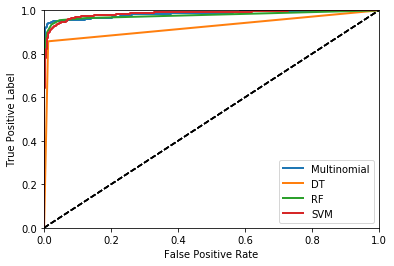

In [20]:
plot_roc_curve(fpr_MNB,tpr_MNB,"Multinomial")
plot_roc_curve(fpr_DT,tpr_DT,"DT")
plot_roc_curve(fpr_RF,tpr_RF,"RF")
plot_roc_curve(fpr_SVM,tpr_SVM,"SVM")

There is a tradeoff between TPR and FPR. Higher the TPR, higher will be the FPR. A good classifier will stay as far away from the dotted lines, ie to the top left corner. To check which classifier performs better, calculate the Area Under Curve score. A good classifier wil have ROC AUC score 1. 

In [21]:
from sklearn.metrics import roc_auc_score
auc_MNB=roc_auc_score(ytrain, MNB_scores1)
auc_DT=roc_auc_score(ytrain, DT_scores1)
auc_RF=roc_auc_score(ytrain, RF_scores1)
auc_SVM=roc_auc_score(ytrain, SVM_scores1)

In [22]:
print ("ROC-AUC Score of Multinomial NB: ",auc_MNB)
print ("ROC-AUC Score of Decision Tree: ",auc_DT)
print ("ROC-AUC Score of Random Forest: ",auc_RF)
print ("ROC-AUC Score of Support Vector Machine: ",auc_SVM)

ROC-AUC Score of Multinomial NB:  0.9841830048341882
ROC-AUC Score of Decision Tree:  0.9227226373664524
ROC-AUC Score of Random Forest:  0.9775158174291144
ROC-AUC Score of Support Vector Machine:  0.9855338870518395


The ROC AUC score of SVM is clearly the largest, hence SVM is the best performing model followed by Decision Tree. We will optimize the hyperparameters of SVM using GridSearch. GridSearchCV is a built-in function in sklearn which allows us to find the optimal parameters of a model. 

## Hyperparameter Optimization  